In [1]:
!pip install snowflake-connector-python pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 kB 6.4 MB/s eta 0:00:00


In [2]:
import snowflake.connector
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Connect to Snowflake
conn = snowflake.connector.connect(
    user='connorjfq',
    password='Group_project1',
    account='GTNADPW-LHB58441',
    warehouse='PROJECT_WH',
    database='PROJECT_DB',
    schema='RAW_DATA_SCHEMA'
)

# SQL query to select data
query = """
SELECT DATE, LAT, LONG, CURRENT_SPEED, FREE_SPEED
FROM TRAFFIC_DATA
"""
df = pd.read_sql(query, conn)


<ipython-input-2-221e1699aac1>:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [3]:
# Calculate speed ratio and normalized speed
df['speed_ratio'] = df['CURRENT_SPEED'] / df['FREE_SPEED']
df['normalized_speed'] = df['FREE_SPEED'] / df['FREE_SPEED'].min()

In [4]:
# Define features and target variable
X = df[['LAT', 'LONG', 'FREE_SPEED', 'normalized_speed']]
y = df['CURRENT_SPEED']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)


In [6]:
# Assuming y_pred is already computed as shown in your previous code snippets

# Add 'CURRENT_SPEED' to X_test for displaying
X_test['CURRENT_SPEED'] = y_test  # y_test contains the actual CURRENT_SPEED values

# Add predictions to the test DataFrame
X_test['predicted_speed'] = y_pred

# Display the test DataFrame with actual and predicted speeds
display(X_test)


,LAT,LONG,FREE_SPEED,normalized_speed,CURRENT_SPEED,predicted_speed
51117,37.360483,-121.875002,106.0,4.818182,57.0,98.880925
168371,37.352346,-121.937682,45.0,2.045455,45.0,40.654905
66661,37.349503,-121.932887,51.0,2.318182,43.0,46.137219
103692,37.359866,-121.941321,62.0,2.818182,49.0,57.605235
244812,37.337785,-121.917373,39.0,1.772727,39.0,33.495027
...,...,...,...,...,...,...
307880,37.367615,-121.880901,44.0,2.000000,33.0,39.900360
326716,37.344316,-121.907998,47.0,2.136364,47.0,41.512848
127856,37.370459,-121.895930,37.0,1.681818,37.0,33.621141
24452,37.358519,-121.871215,107.0,4.863636,107.0,99.637604


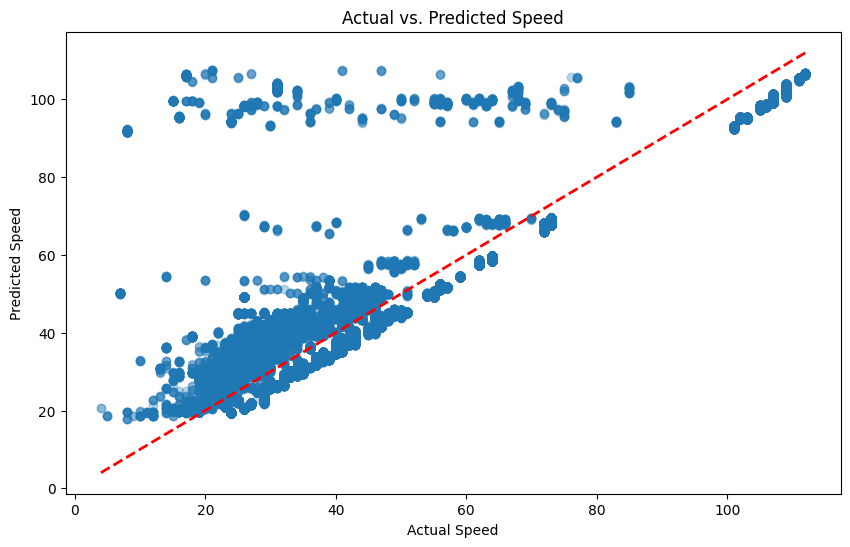

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Speed')
plt.ylabel('Predicted Speed')
plt.title('Actual vs. Predicted Speed')
plt.show()


In [15]:
X_test['is_congested'] = X_test['predicted_speed'] < 0.8 * X_test['FREE_SPEED']

# Display the test DataFrame with actual and predicted speeds along with congestion flags
display(X_test)

,LAT,LONG,FREE_SPEED,normalized_speed,CURRENT_SPEED,predicted_speed,is_congested,CONGESTION_PERCENT
51117,37.360483,-121.875002,106.0,4.818182,57.0,98.880925,False,6.716108
168371,37.352346,-121.937682,45.0,2.045455,45.0,40.654905,False,9.655766
66661,37.349503,-121.932887,51.0,2.318182,43.0,46.137219,False,9.534864
103692,37.359866,-121.941321,62.0,2.818182,49.0,57.605235,False,7.088330
244812,37.337785,-121.917373,39.0,1.772727,39.0,33.495027,False,14.115316
...,...,...,...,...,...,...,...,...
307880,37.367615,-121.880901,44.0,2.000000,33.0,39.900360,False,9.317364
326716,37.344316,-121.907998,47.0,2.136364,47.0,41.512848,False,11.674792
127856,37.370459,-121.895930,37.0,1.681818,37.0,33.621141,False,9.132053
24452,37.358519,-121.871215,107.0,4.863636,107.0,99.637604,False,6.880744


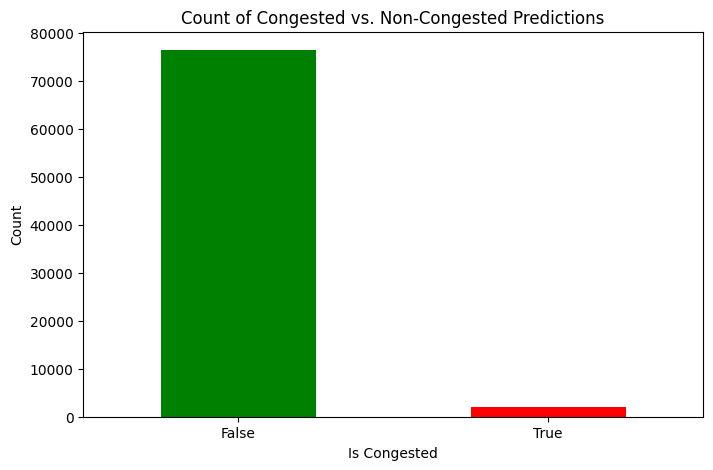

In [16]:
# Count the number of True and False values in the 'is_congested' column
congestion_counts = X_test['is_congested'].value_counts()

# Create a bar graph
plt.figure(figsize=(8, 5))
congestion_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Count of Congested vs. Non-Congested Predictions')
plt.xlabel('Is Congested')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
